In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy.optimize import minimize

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = date.today()
print(end_date)
start_date = end_date - timedelta(days=5*365)

2024-05-18


In [5]:
adj_close_df = pd.DataFrame()

In [6]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-05-20  262.017212  71.164291  120.639999  174.209305  134.053757
2019-05-21  264.379547  71.129189  120.360001  176.029373  135.364792
2019-05-22  263.567444  71.260818  120.239998  175.245178  134.875427
2019-05-23  260.347107  71.515251  121.169998  172.563538  133.158249
2019-05-24  260.937622  71.515251  121.300003  172.476425  133.481384
...                ...        ...         ...         ...         ...
2024-05-13  520.909973  71.440002  216.259995  443.079987  258.190002
2024-05-14  523.299988  71.650002  218.089996  445.929993  259.450012
2024-05-15  529.780029  72.110001  220.889999  452.899994  262.640015
2024-05-16  528.690002  71.989998  220.029999  451.980011  261.929993
2024-05-17  528.900024  71.828003  223.440002  451.450012  262.025085

[1259 rows x 5 columns]


In [8]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [9]:
log_returns=log_returns.dropna()

In [10]:
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-05-21,0.008976,-0.000493,-0.002324,0.010393,0.009732
2019-05-22,-0.003076,0.001849,-0.000998,-0.004465,-0.003622
2019-05-23,-0.012294,0.003564,0.007705,-0.015421,-0.012813
2019-05-24,0.002266,0.000000,0.001072,-0.000505,0.002424
2019-05-28,-0.009344,0.002084,-0.003882,-0.003768,-0.008823
...,...,...,...,...,...
2024-05-13,0.000134,0.000840,-0.011265,0.002305,0.000542
2024-05-14,0.004578,0.002935,0.008426,0.006412,0.004868
2024-05-15,0.012307,0.006400,0.012757,0.015509,0.012220


In [11]:
cov_matrix = log_returns.cov() * 252

In [12]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044167  0.002903  0.003855  0.049794  0.045222
BND  0.002903  0.004771  0.003860  0.003519  0.003092
GLD  0.003855  0.003860  0.023053  0.005116  0.004046
QQQ  0.049794  0.003519  0.005116  0.064692  0.050931
VTI  0.045222  0.003092  0.004046  0.050931  0.046680


In [13]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [14]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [15]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000
Expected Annual Return: 0.1538
Expected Volatility: 0.1613
Sharpe Ratio: 0.8295


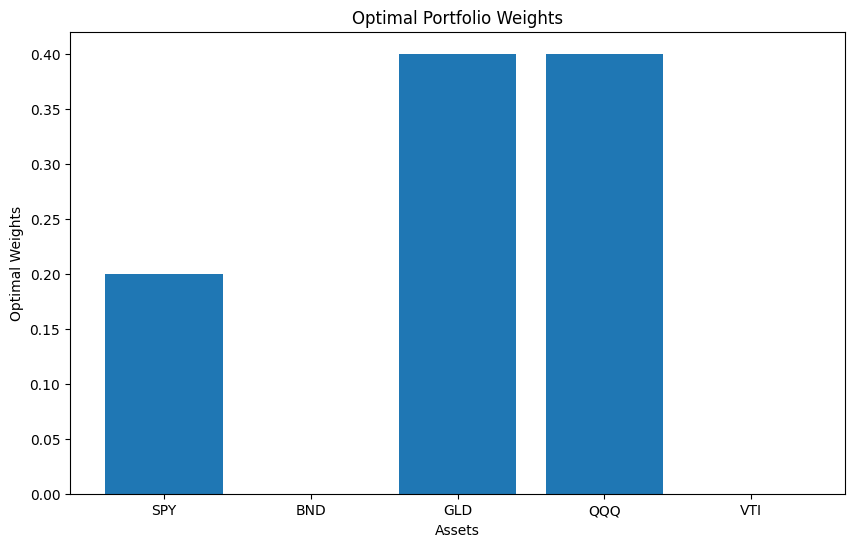

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()